## 1. 初始準備

In [12]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [14]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

## 2. 讀入 MNIST 數據庫

In [15]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

調整資料長相及單位化

In [16]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

# 3. Autoencoder

Autoencoder，又稱為自編碼器，是一個將資料壓縮再還原的模型，通常由一編碼器及一解碼器所組成。

給定一組數據集 $\mathcal{D}\subseteq\mathbb{R}^n$ 以及一個壓縮維度 $m$，其中 $m < n$。

數學上來說表示，Autoencoder 由 $\mbox{Enc}:\mathbb{R}^n\to\mathbb{R}^m$ 和 $\mbox{Dec}:\mathbb{R}^m\to\mathbb{R}^n$ 所構成：

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

且對於任意的 $x\in\mathcal{D}$，我們希望 $x\approx\hat{x} = Dec(h) = Dec\big(Enc(x)\big)$

其中，$h = \mbox{Enc}(x)$ 稱之 $x$ 為潛在表示法 (latent representation)，而 $\hat{x}$ 則是 $x$ 自編碼過後的還原資料。

換言之，我們希望原本的資料 $x$，經過函數 $\mbox{Enc}$ 編碼成維度比較小的資料 $h$，再透過函數 $\mbox{Dec}$ 還原成 $\hat{x}$。

一般而言，我們會希望 $\mbox{Enc}$ 和 $\mbox{Dec}$  看起來有點對稱。

**為了視覺化的目的，經常會考慮 $m=2$ 的狀況。**

## 3.1 Autoencoder 與手寫辨識資料 MNIST

我們考慮具有下列結構的 Autoencoder:
$$ x \overset{\mbox{Enc}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

In [20]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

In [21]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_11 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_12 (Dense)             (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

## 3.2 視覺化 - 子模型的取出
為了視覺化(及其他潛在應用)，我們也會從 Autoencoder 將 Encoder 和 Decoder 分別定義出來。

In [23]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


Decoder 是由 $h$ 開始，因此，我們先準備一個與 $h$ 相同大小的 `Input`，並餵進 `dec_2` 及 `dec_1` 中即可。

In [24]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_12 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## 3.3 視覺化 - Encoder

首先，我們隨便抽取一張圖，並透過 Encoder 來算出它的 latent 表示。

In [26]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 678 圖的 latent 表示為 [[0.92742413 0.9998584 ]]


接者，我們從 $10000$ 筆測試資料隨機挑選 $3000$ 手寫辨識資料，將其轉換成 latent 表示法，並畫在同一平面上。

In [27]:
indices = np.random.randint(x_test.shape[0], size=3000)

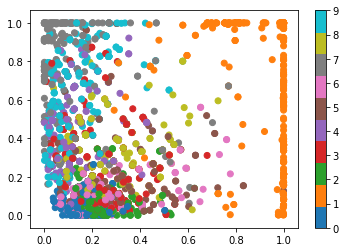

In [28]:
latents = Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

### 2.4 視覺化 - Decoder

首先，我們在 $[0, 1]\times[0, 1]$ 這個單位正方形內均勻取樣 $15*15$ 個點，並將這 $225$ 個平面上的點，透過 Decoder 進行圖片的還原。

In [29]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [30]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

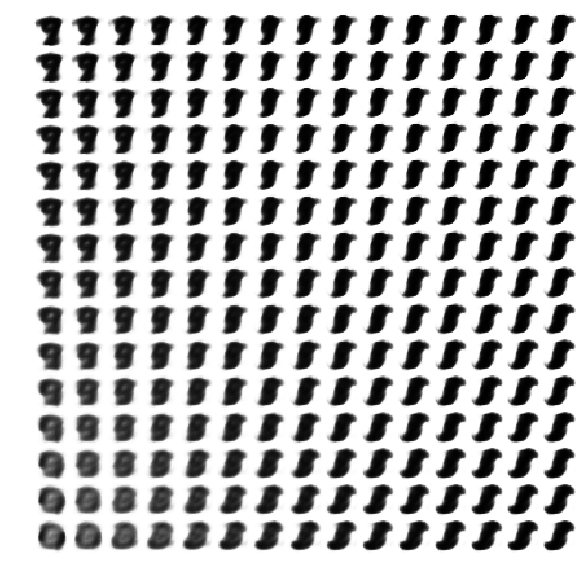

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

# 4.Variational Autoencoder
若每筆資料的 latent 不僅僅是一個**位置**，而是一個分布，且分布的平均值附近都能還原，那我們應該怎麼做呢？

在此，我們將介紹 Variational Autoencder，一種當代知名的自編碼器，就具有上述的效果。

此時 $\mbox{Enc}$ 和 $\mbox{Dec}$ 並不直接串接，而是會透過一常態抽樣的函數以下面的形式串接。

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m\times\mathbb{R}^m \overset{\mbox{Sampling}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$


在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，平均數與變異數。

而 Decoder 也不再直接使用 Encoder 的結果，而是將 Encoder 的結果作為常態抽樣的兩個參數來進行。

因此，資料經過 Encoder，會得到一適當大小的常態分配之參數，而 Decoder 則使用這組參數進行抽樣。

即使是同一筆資料，Decoder 每次接受到的 latent 表示法可能都不一樣 (但會在某個平均數附近)。

要注意到的是，由於變異數恆正的特性，我們可以下面是以學習取對數後的變異數 (log-variance)。

## 4.1 VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層

In [32]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [33]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數並透過 ``Lambda`` 將其轉換成 Keras layer。

透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [34]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [35]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [36]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [37]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 100)          78500       input_5[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2)            202         dense_13[0][0]                   
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 2)            202         dense_13[0][0]                   
__________________________________________________________________________________________________
lambda_1 (

## 4.2 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

同學有興趣可以證明下面關於 KL 散度在兩個常態分配上的性質：若 $p\sim N(\mu_1,\sigma_1^2)$, $q\sim N(\mu_2,\sigma_2^2)$，則 $KL(p, q) = \log\dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}$

In [40]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

## 4.3 訓練 VAE

In [41]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [44]:
# VAE.save_weights('VAE_handwriting_model_weights.h5')
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 4.4 VAE 的視覺化呈現
與視覺化 Autoencoder 時的方式一樣，我們先分別定義出 Encoder 和 Decoder。

$$\mbox{VAE:}~x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$
$$\mbox{Encoder:}~x \overset{\mbox{Enc}}{\mapsto} \mu$$
$$\mbox{Decoder:}~h \overset{\mbox{Dec}}{\mapsto} \hat{x}$$

In [45]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [29]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


首先，我們進行 Encoder 的視覺化呈現。

In [48]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 3898 圖的 latent 表示為 [[2.3037922 1.641819 ]]


In [49]:
# indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

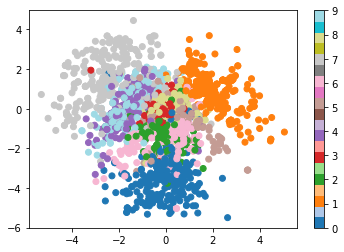

In [50]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

接著，我們進行 Decoder 的視覺化呈現。

In [51]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [52]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

NameError: name 'VAE_Decoder' is not defined

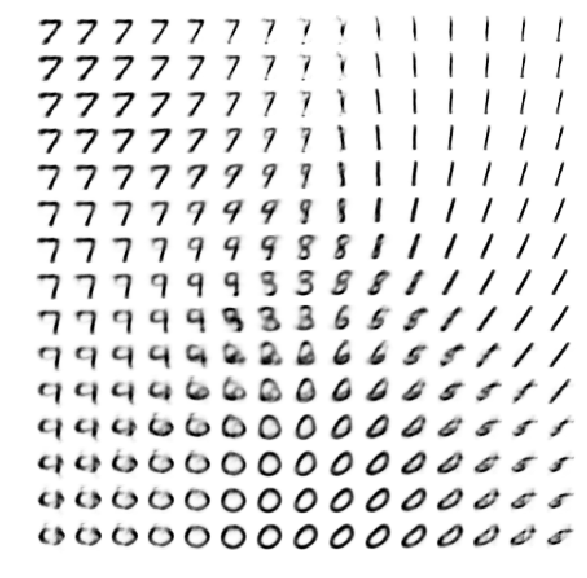

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

## 4.5 與 Autoencoder 的 Encoder 進行視覺化比較

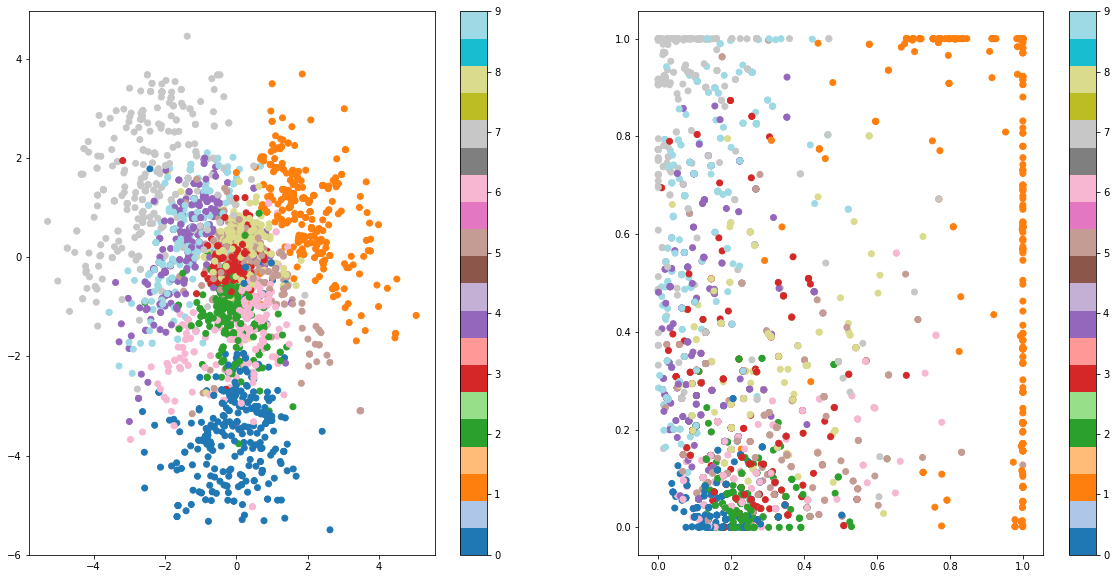

In [53]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

## 4.6 動態比較

In [58]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [79]:
def inBetween(t, idx1, idx2):
    if(type(idx1) != int or type(idx2) != int):
        raise TypeError
    elif(0 > idx1 or 9 < idx1):
        raise ValueError
    elif(0 > idx2 or 9 < idx2):
        raise ValueError
    
    findNum1 = np.where(y_train0 == idx1)   
    findNum2 = np.where(y_train0 == idx2)
    
    idx_1 = findNum1[0][0]
    idx_2 = findNum2[0][0]
    
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [80]:
import ipywidgets as widgets
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,)
        , idx1 = widgets.IntSlider(min=0,max=9,step=1,value=1)
        , idx2 = widgets.IntSlider(min=0,max=9,step=1,value=3))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), IntSlider(value=1, descript…

<function __main__.inBetween(t, idx1, idx2)>